In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
##########   Load and Preprocess the Data   ##########
# Load the data
data = pd.read_csv('MSFT.csv', parse_dates=['Date'])
data = data[(data['Date'] >= '1987-01-01') & (data['Date'] <= '2021-12-31')]
data = data[['Date', 'Close']]

# Normalize the data
prices = ((data['Close'] - data['Close'].mean()) / data['Close'].std()).values

In [3]:
##########   Create a Dataset Class   ##########
class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        x = self.data[index:index+self.seq_length]
        y = self.data[index+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [4]:
##########   Split the dataset into training and testing   ##########
training_start = '1987-01-01'
training_end = '2017-12-31'
test_start = '2018-01-01'
test_end = '2021-12-31'

seq_length = 10

train_indices = ((data['Date'] >= training_start) & (data['Date'] <= training_end)).values
test_indices = ((data['Date'] >= test_start) & (data['Date'] <= test_end)).values

train_dataset = StockDataset(prices[train_indices], seq_length)
test_dataset = StockDataset(prices[test_indices], seq_length)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_predict_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
##########   Build the LSTM Model   ##########
class StockPricePredictor(nn.Module):
    def __init__(self, input_size=1, hidden1_size=256, hidden2_size=256, dense1_size=128, dense2_size=64):
        super(StockPricePredictor, self).__init__()
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        
        self.lstm1 = nn.LSTM(input_size, hidden1_size, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden1_size, hidden2_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden2_size, dense1_size)
        self.fc2 = nn.Linear(dense1_size, dense2_size)
        self.fc3 = nn.Linear(dense2_size, 1)
        
    def forward(self, x):
        h0_1 = torch.zeros(1, x.size(0), self.hidden1_size).to(x.device)
        c0_1 = torch.zeros(1, x.size(0), self.hidden1_size).to(x.device)
        
        out, _ = self.lstm1(x, (h0_1, c0_1))
        
        h0_2 = torch.zeros(1, out.size(0), self.hidden2_size).to(x.device)
        c0_2 = torch.zeros(1, out.size(0), self.hidden2_size).to(x.device)
        
        out, _ = self.lstm2(out, (h0_2, c0_2))
        
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPricePredictor().to(device)


Is CUDA supported by this system? True


In [6]:
##########   Train the Model   ##########
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    batch_train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        outputs = model(inputs).squeeze(-1)  # Remove extra dimension
        
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())
    
    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    
    # Validation loss
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for inputs, targets in train_predict_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            outputs = model(inputs).squeeze(-1)
            
            val_loss = criterion(outputs, targets)
            batch_val_losses.append(val_loss.item())
    
    val_loss = np.mean(batch_val_losses)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')


Epoch [1/20], Train Loss: 0.01334314, Val Loss: 0.00035307
Epoch [2/20], Train Loss: 0.00036832, Val Loss: 0.00037388
Epoch [3/20], Train Loss: 0.00033802, Val Loss: 0.00029911
Epoch [4/20], Train Loss: 0.00032357, Val Loss: 0.00033946
Epoch [5/20], Train Loss: 0.00032256, Val Loss: 0.00025606
Epoch [6/20], Train Loss: 0.00032858, Val Loss: 0.00041838
Epoch [7/20], Train Loss: 0.00027184, Val Loss: 0.00020641
Epoch [8/20], Train Loss: 0.00024277, Val Loss: 0.00025632
Epoch [9/20], Train Loss: 0.00022294, Val Loss: 0.00023882
Epoch [10/20], Train Loss: 0.00022843, Val Loss: 0.00015469
Epoch [11/20], Train Loss: 0.00018069, Val Loss: 0.00016057
Epoch [12/20], Train Loss: 0.00018042, Val Loss: 0.00015267
Epoch [13/20], Train Loss: 0.00017615, Val Loss: 0.00020680
Epoch [14/20], Train Loss: 0.00013759, Val Loss: 0.00013574
Epoch [15/20], Train Loss: 0.00012912, Val Loss: 0.00010536
Epoch [16/20], Train Loss: 0.00012082, Val Loss: 0.00011588
Epoch [17/20], Train Loss: 0.00013804, Val Loss: 

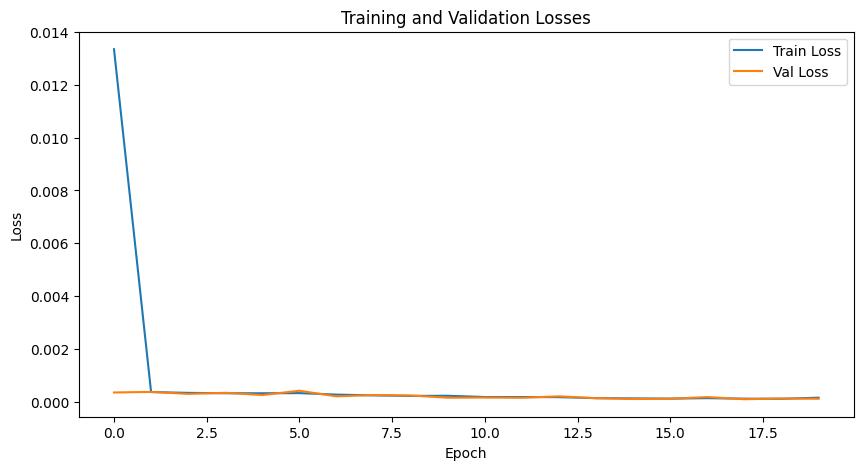

In [7]:
##########   Plot the Training and Validation Losses   ##########
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [8]:
##########   Make Predictions   ##########
model.eval()

test_predictions = []
test_actuals = []

with torch.no_grad():
    for inputs, targets in DataLoader(test_dataset, batch_size=1, shuffle=False):
        inputs = inputs.to(device).unsqueeze(-1)
        prediction = model(inputs).squeeze(-1)
        test_predictions.append(prediction.item())
        test_actuals.append(targets.item())

test_predictions = np.array(test_predictions)
test_actuals = np.array(test_actuals)

test_predictions = (test_predictions * data['Close'].std()) + data['Close'].mean()
test_actuals = (test_actuals * data['Close'].std()) + data['Close'].mean()



model.eval()

train_predictions = []
train_actuals = []

with torch.no_grad():
    for inputs, targets in DataLoader(train_dataset, batch_size=1, shuffle=False):
        inputs = inputs.to(device).unsqueeze(-1)
        prediction = model(inputs).squeeze(-1)
        train_predictions.append(prediction.item())
        train_actuals.append(targets.item())

train_predictions = np.array(train_predictions)
train_actuals = np.array(train_actuals)

train_predictions = (train_predictions * data['Close'].std()) + data['Close'].mean()
train_actuals = (train_actuals * data['Close'].std()) + data['Close'].mean()


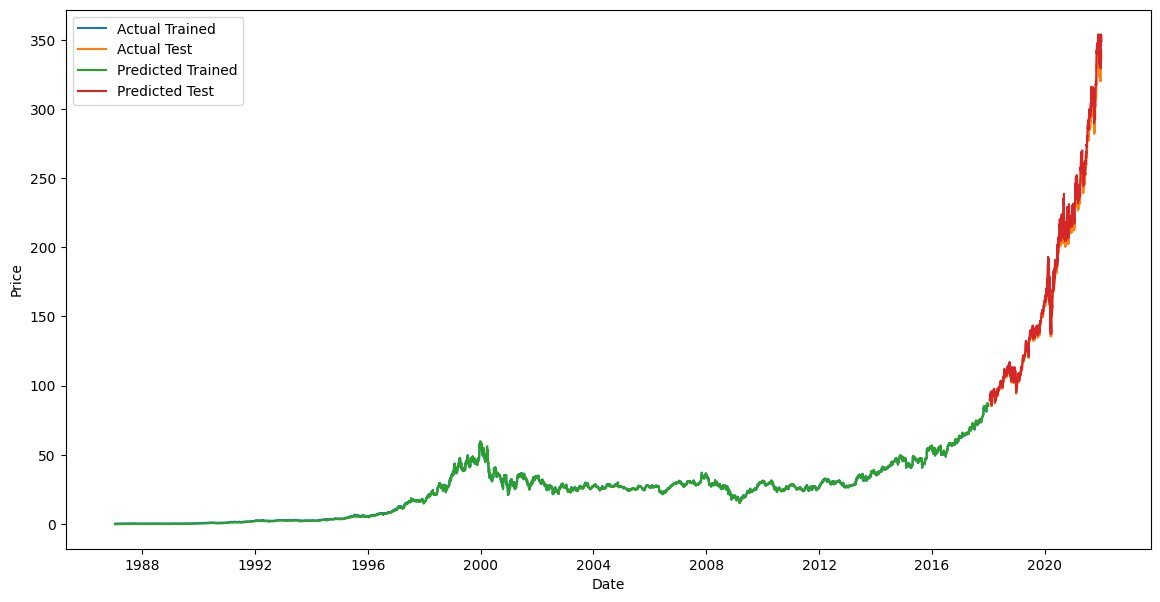

0.832769 M parameters


In [9]:
##########   Plot the Results   ##########
plt.figure(figsize=(14,7))

# Plot the actual training values
plt.plot(data['Date'][train_indices][seq_length:], train_actuals, label='Actual Trained')

# Plot the actual test values
plt.plot(data['Date'][test_indices][seq_length:], test_actuals, label='Actual Test')

# Plot the training predictions
plt.plot(data['Date'][train_indices][seq_length:], train_predictions, label='Predicted Trained')

# Plot the testing predictions
plt.plot(data['Date'][test_indices][seq_length:], test_predictions, label='Predicted Test')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')